Imports

In [2]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
    r2_score,
)
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

Read data

In [3]:
maindf = pd.read_csv('./BTC_USD.csv')
print("Total number of days present in the dataset: ", maindf.shape[0])
print("Total number of fields present in the dataset: ", maindf.shape[1])


# Check for null and NA values

print('Null Values: ', maindf.isnull().values.sum())
print("NA values:", maindf.isnull().values.any())

#Data shape + look
maindf.shape

maindf.describe()

Total number of days present in the dataset:  3621
Total number of fields present in the dataset:  7
Null Values:  0
NA values: False


,Open,High,Low,Close,Adj Close,Volume
count,3621.000000,3621.000000,3621.000000,3621.000000,3621.000000,3.621000e+03
mean,17430.522947,17827.991156,17004.375770,17444.936800,17444.936800,1.751433e+10
std,19305.417630,19740.040312,18824.610395,19312.520889,19312.520889,1.921478e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1116.319946,1151.739990,1077.250000,1117.439941,1117.439941,2.721670e+08
50%,9048.460938,9217.835938,8811.366211,9045.390625,9045.390625,1.367521e+10
75%,28522.097656,29159.902344,28174.251953,28627.574219,28627.574219,2.828269e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,3.509679e+11


Closing Price Data

In [4]:


closedf = maindf[["Date", "Close"]]
print("Shape of close dataframe:", closedf.shape)

fig = px.line(
    closedf,
    x=closedf.Date,
    y=closedf.Close,
    labels={"date": "Date", "close": "Close Stock"},
)
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color="orange")
fig.update_layout(
    title_text="Bitcoin closing price in USD 2014-2022",
    plot_bgcolor="white",
    font_size=15,
    font_color="black",
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Shape of close dataframe: (3621, 2)


Feature Selection

In [5]:

close = maindf["Close"]

print("Shape of close dataframe:", closedf.shape)


# maindf = maindf.drop('Date', axis=1)
maindf.head()


Shape of close dataframe: (3621, 2)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Normalisation

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
close = scaler.fit_transform(np.array(close).reshape(-1,1))
print(close.shape)

(3621, 1)


Preparing training + testing data

In [7]:
training_size = int(len(close) * 0.70)
test_size = len(close) - training_size
train_data, test_data = (
    close[0:training_size, :],
    close[training_size : len(close), :1],
)
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2534, 1)
test_data:  (1087, 1)


In [8]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i + time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2518, 15)
y_train:  (2518,)
X_test:  (1071, 15)
y_test (1071,)


In [14]:
# reshape input to be [samples, time steps, features] which is required for LSTM
print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#print(X_train)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

(2518, 15, 1)
X_train:  (2518, 15, 1)
X_test:  (1071, 15, 1)


Build Model

In [15]:
model = Sequential()

model.add(LSTM(100, input_shape=(None, 1), activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

In [16]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1,
)

Epoch 1/200
79/79 [==============================] - 1s 5ms/step - loss: 0.0118 - val_loss: 0.0244
Epoch 2/200
79/79 [==============================] - 0s 3ms/step - loss: 7.2401e-04 - val_loss: 7.4053e-04
Epoch 3/200
79/79 [==============================] - 0s 3ms/step - loss: 1.8746e-04 - val_loss: 7.0824e-04
Epoch 4/200
79/79 [==============================] - 0s 3ms/step - loss: 1.7980e-04 - val_loss: 6.9014e-04
Epoch 5/200
79/79 [==============================] - 0s 3ms/step - loss: 1.7505e-04 - val_loss: 5.6580e-04
Epoch 6/200
79/79 [==============================] - 0s 3ms/step - loss: 1.6697e-04 - val_loss: 5.6104e-04
Epoch 7/200
79/79 [==============================] - 0s 3ms/step - loss: 1.6451e-04 - val_loss: 5.3802e-04
Epoch 8/200
79/79 [==============================] - 0s 3ms/step - loss: 1.6542e-04 - val_loss: 5.3190e-04
Epoch 9/200
79/79 [==============================] - 0s 3ms/step - loss: 1.5804e-04 - val_loss: 5.2732e-04
Epoch 10/200
79/79 [=========================

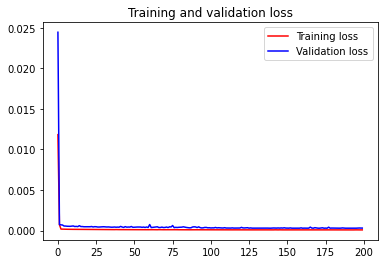

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend(loc=0)
plt.figure()


plt.show()

In [18]:
### Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape, test_predict.shape

((2518, 1), (1071, 1))

In [19]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Evaluation metrices RMSE and MAE
print(
    "Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict))
)
print("Train data MSE: ", mean_squared_error(original_ytrain, train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict))
print(
    "-------------------------------------------------------------------------------------"
)
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest, test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict))

Train data RMSE:  708.9628899504788
Train data MSE:  502628.37932693475
Train data MAE:  429.5139127159382
-------------------------------------------------------------------------------------
Test data RMSE:  1283.6645593589662
Test data MSE:  1647794.700954249
Test data MAE:  877.8817793868465
